# 1. Setup and Get Data

### 1.1 Install Dependencies and Setup

In [1]:
!pip install labelme tensorflow tensorflow-gpu opencv-python matplotlib albumentations

  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
    Preparing wheel metadata: started
    Preparing wheel metadata: finished with status 'done'
  Created wheel for labelme: filename=labelme-5.0.1-py3-none-any.whl size=1466183 sha256=b0a7de60d7e6db8e13637a26e8fe61843a93700a5883aa68d7a64bfdde42e8b3
  Stored in directory: c:\users\soshi\appdata\local\pip\cache\wheels\29\9b\b4\41b9f5488d5859bef0cf383385f88ac4bcc521b19b47a71a4c
  Created wheel for imgviz: filename=imgviz-1.5.0-py3-none-any.whl size=7680458 sha256=803e9ffbb2fbfb3eadcad4f3223e714bfa86ec7ae5ce0d8d0f4fc9f09676e4b6
  Stored in directory: c:\users\soshi\appdata\local\pip\cache\wheels\0b\c0\9b\c8285baf71d6ff5fae7a54825a52d0c91462e7e483b03e8326
Successfully built labelme imgviz
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.3.4
    U

### 1.2 Collect Images Using OpenCV

In [1]:
import os
import time
import uuid
import cv2

In [2]:
IMAGES_PATH = os.path.join('data','images')
try:
    os.makedirs(IMAGES_PATH)
except Exception:
    print("Something goes wrong.")
number_images = 30

Something goes wrong.


In [12]:
cap = cv2.VideoCapture(0)
for imgnum in range(number_images):
    print('Collecting image {}'.format(imgnum))
    ret, frame = cap.read()
    imgname = os.path.join(IMAGES_PATH,f'{str(uuid.uuid1())}.jpg')
    cv2.imwrite(imgname, frame)
    cv2.imshow('frame', frame)
    time.sleep(0.5)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

error: OpenCV(4.5.5) D:\a\opencv-python\opencv-python\opencv\modules\imgcodecs\src\loadsave.cpp:801: error: (-215:Assertion failed) !_img.empty() in function 'cv::imwrite'


### 1.3 Annotate Images with LabelMe

In [335]:
!labelme

[INFO   ] __init__:get_config:70 - Loading config file from: C:\Users\soshi\.labelmerc
External WM_DESTROY received for  QWidgetWindow(0x1baab862760, name="LabelDialogClassWindow") , parent:  QWindow(0x0) , transient parent:  QWidgetWindow(0x1baab428980, name="MainWindowClassWindow")


# 2. Review Dataset and Build Image Loading Function

### 2.1 Import TF and Deps

In [3]:
import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt

### 2.2 Limit GPU Memory Growth

In [336]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [337]:
tf.config.list_physical_devices('GPU')

[]

### 2.3 Load Image into TF Data Pipeline

In [476]:
images = tf.data.Dataset.list_files('data\\images\\*.jpg')

InvalidArgumentError: Expected 'tf.Tensor(False, shape=(), dtype=bool)' to be true. Summarized data: b'No files matched pattern: data\\images\\*.jpg'

In [477]:
images.as_numpy_iterator().next()

UnicodeDecodeError: 'utf-8' codec can't decode byte 0xa8 in position 70: invalid start byte

In [340]:
def load_image(x): 
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [341]:
images = images.map(load_image)

In [342]:
images.as_numpy_iterator().next()

array([[[205, 214, 211],
        [204, 213, 210],
        [202, 211, 208],
        ...,
        [218, 214, 202],
        [218, 214, 202],
        [218, 214, 202]],

       [[205, 214, 211],
        [204, 213, 210],
        [203, 212, 209],
        ...,
        [218, 214, 202],
        [218, 214, 202],
        [218, 214, 202]],

       [[206, 215, 212],
        [205, 214, 211],
        [203, 212, 209],
        ...,
        [217, 213, 201],
        [217, 213, 201],
        [217, 213, 201]],

       ...,

       [[230, 219, 197],
        [230, 219, 197],
        [230, 219, 197],
        ...,
        [219, 214, 192],
        [219, 214, 192],
        [218, 213, 191]],

       [[229, 218, 198],
        [229, 218, 198],
        [230, 219, 199],
        ...,
        [217, 215, 194],
        [216, 214, 193],
        [216, 214, 193]],

       [[229, 218, 198],
        [229, 218, 198],
        [229, 218, 198],
        ...,
        [218, 216, 195],
        [216, 214, 193],
        [216, 214, 193]]

In [343]:
type(images)

tensorflow.python.data.ops.dataset_ops.MapDataset

### 2.4 View Raw Images with Matplotlib

In [344]:
image_generator = images.batch(4).as_numpy_iterator()

In [345]:
plot_images = image_generator.next()

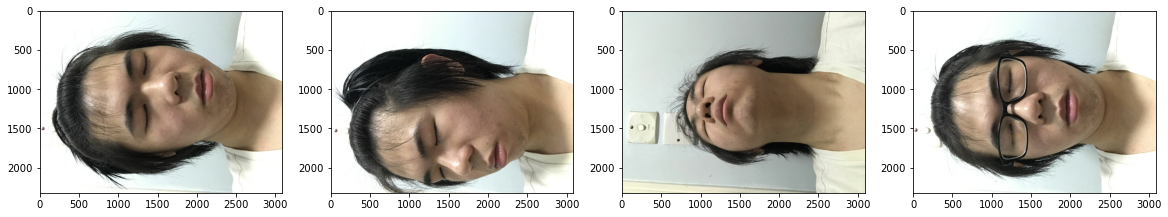

In [346]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image) 
plt.show()

# 3. Partition Unaugmented Data

### 3.1 MANUALLY SPLT DATA INTO TRAIN TEST AND VAL

In [ ]:
90*.7 # 63 to train

In [ ]:
90*.15 # 14 and 13 to test and val

### 3.2 Move the Matching Labels

In [347]:
for folder in ['train','test','val']:
    for file in os.listdir(os.path.join('data', folder, 'images')):
        
        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join('data','labels', filename)
        if os.path.exists(existing_filepath): 
            new_filepath = os.path.join('data',folder,'labels',filename)
            os.replace(existing_filepath, new_filepath)

# 4. Apply Image Augmentation on Images and Labels using Albumentations

### 4.1 Setup Albumentations Transform Pipeline

In [4]:
import albumentations as alb

In [5]:
augmentor = alb.Compose([alb.RandomCrop(width=450, height=450), 
                         alb.HorizontalFlip(p=0.5), 
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2), 
                         alb.RGBShift(p=0.2), 
                         alb.VerticalFlip(p=0.5)], 
                       bbox_params=alb.BboxParams(format='albumentations', 
                                                  label_fields=['class_labels']))

### 4.2 Load a Test Image and Annotation with OpenCV and JSON

In [434]:
imgSize = (480, 640)

In [435]:
img = cv2.imread(os.path.join('data','train', 'images','IMG_6730.jpg'))

img = cv2.resize(img, imgSize)

In [436]:
img.shape

(480, 640, 3)

In [437]:
with open(os.path.join('data', 'train', 'labels', 'IMG_6730.json'), 'r') as f:
    label = json.load(f)

In [438]:
label['shapes'][0]['points']

[[353.9787234042551, 1047.9574468085107],
 [1698.6595744680849, 1488.3829787234042]]

### 4.3 Extract Coordinates and Rescale to Match Image Resolution

In [439]:
coords = [0,0,0,0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]

In [440]:
coords

[353.9787234042551, 1047.9574468085107, 1698.6595744680849, 1488.3829787234042]

In [441]:
coords = list(np.divide(coords, [640,480,640,480]))

In [442]:
coords

[0.5530917553191486,
 2.1832446808510637,
 2.6541555851063827,
 3.1007978723404253]

### 4.4 Apply Augmentations and View Results

In [443]:
augmented = augmentor(image=img, bboxes=[coords], class_labels=['close'])

ValueError: Expected y_min for bbox [0.5530917553191486, 2.1832446808510637, 2.6541555851063827, 3.1007978723404253, 'close'] to be in the range [0.0, 1.0], got 2.1832446808510637.

In [360]:
augmented['bboxes'][0][2:]

(0.7124422442244225, 0.6210927759442612)

In [361]:
augmented['bboxes']

[(0.43686468646864685,
  0.4538760542720939,
  0.7124422442244225,
  0.6210927759442612)]

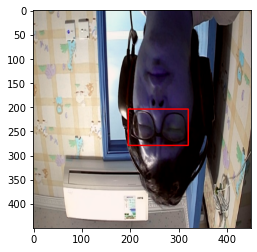

In [362]:
cv2.rectangle(augmented['image'], 
              tuple(np.multiply(augmented['bboxes'][0][:2], [450,450]).astype(int)),
              tuple(np.multiply(augmented['bboxes'][0][2:], [450,450]).astype(int)), 
                    (255,0,0), 2)

plt.imshow(augmented['image'])

# 5. Build and Run Augmentation Pipeline

### 5.1 Run Augmentation Pipeline

In [444]:
imgSize = (480, 640)

for partition in ['train','test','val']: 
    for image in os.listdir(os.path.join('data', partition, 'images')):
        img = cv2.imread(os.path.join('data', partition, 'images', image))
        img = cv2.resize(img,imgSize)

        coords = [0,0,0.00001,0.00001]
        label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords, [640,480,640,480]))

        try: 
            for x in range(60):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['close'])
                cv2.imwrite(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0: 
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0 
                    else: 
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else: 
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0 


                with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)

Expected y_min for bbox [0.5530917553191486, 2.1832446808510637, 2.6541555851063827, 3.1007978723404253, 'close'] to be in the range [0.0, 1.0], got 2.1832446808510637.
Expected y_min for bbox [0.32370345744680834, 2.138918439716312, 2.102293882978723, 2.9279255319148936, 'close'] to be in the range [0.0, 1.0], got 2.138918439716312.
Expected y_min for bbox [0.3070811170212764, 2.2718971631205673, 2.265192819148936, 2.8215425531914895, 'close'] to be in the range [0.0, 1.0], got 2.2718971631205673.
Expected y_min for bbox [0.3901928191489361, 2.1832446808510637, 2.138863031914893, 2.9279255319148936, 'close'] to be in the range [0.0, 1.0], got 2.1832446808510637.
Expected x_min for bbox [1.4506981382978723, 2.1034574468085108, 0.07769281914893611, 3.1318262411347515, 'close'] to be in the range [0.0, 1.0], got 1.4506981382978723.
Expected x_min for bbox [1.5238364361702126, 2.014804964539007, 0.1175864361702125, 3.136258865248227, 'close'] to be in the range [0.0, 1.0], got 1.523836436

### 5.2 Load Augmented Images to Tensorflow Dataset

In [445]:
train_images = tf.data.Dataset.list_files('aug_data\\train\\images\\*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120,120)))
train_images = train_images.map(lambda x: x/255)

In [446]:
test_images = tf.data.Dataset.list_files('aug_data\\test\\images\\*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120,120)))
test_images = test_images.map(lambda x: x/255)

In [447]:
val_images = tf.data.Dataset.list_files('aug_data\\val\\images\\*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120,120)))
val_images = val_images.map(lambda x: x/255)

In [448]:
train_images.as_numpy_iterator().next()

array([[[0.46182597, 0.48045343, 0.47506127],
        [0.47175246, 0.49675244, 0.48841912],
        [0.4545956 , 0.4898897 , 0.48302695],
        ...,
        [0.22322305, 0.22322305, 0.21537991],
        [0.20343137, 0.20343137, 0.19816177],
        [0.1721201 , 0.17702205, 0.17457108]],

       [[0.45716912, 0.4728554 , 0.46893382],
        [0.46317402, 0.4858456 , 0.47843137],
        [0.47493872, 0.49846813, 0.490625  ],
        ...,
        [0.22745098, 0.22745098, 0.21960784],
        [0.21574755, 0.21574755, 0.2148897 ],
        [0.18394607, 0.18394607, 0.18394607]],

       [[0.46550244, 0.48511028, 0.469424  ],
        [0.4543505 , 0.47003677, 0.4661152 ],
        [0.47757354, 0.49325982, 0.48933825],
        ...,
        [0.23088235, 0.23088235, 0.22303921],
        [0.22003676, 0.22003676, 0.22003676],
        [0.17022058, 0.17512254, 0.17267157]],

       ...,

       [[0.5101103 , 0.6155025 , 0.6308824 ],
        [0.64276963, 0.70459557, 0.70098037],
        [0.6579044 , 0

# 6. Prepare Labels

### 6.1 Build Label Loading Function

In [449]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)
        
    return [label['class']], label['bbox']

### 6.2 Load Labels to Tensorflow Dataset

In [450]:
train_labels = tf.data.Dataset.list_files('aug_data\\train\\labels\\*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [451]:
test_labels = tf.data.Dataset.list_files('aug_data\\test\\labels\\*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [452]:
val_labels = tf.data.Dataset.list_files('aug_data\\val\\labels\\*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [453]:
train_labels.as_numpy_iterator().next()

(array([1], dtype=uint8),
 array([0.448 , 0.381 , 0.7236, 0.5483], dtype=float16))

# 7. Combine Label and Image Samples

### 7.1 Check Partition Lengths

In [454]:
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

(1020, 1020, 240, 240, 240, 240)

### 7.2 Create Final Datasets (Images/Labels)

In [455]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(5000)
train = train.batch(8)
train = train.prefetch(4)

In [456]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1300)
test = test.batch(8)
test = test.prefetch(4)

In [457]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1000)
val = val.batch(8)
val = val.prefetch(4)

In [458]:
train.as_numpy_iterator().next()[1]

(array([[1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1]], dtype=uint8),
 array([[0.4841 , 0.6562 , 0.749  , 0.8203 ],
        [0.2764 , 0.6562 , 0.5522 , 0.823  ],
        [0.2883 , 0.2396 , 0.587  , 0.4407 ],
        [0.2365 , 0.503  , 0.512  , 0.67   ],
        [0.4243 , 0.10364, 0.691  , 0.2576 ],
        [0.3271 , 0.2217 , 0.5786 , 0.4358 ],
        [0.3125 , 0.6045 , 0.5303 , 0.7715 ],
        [0.3862 , 0.5015 , 0.685  , 0.7026 ]], dtype=float16))

### 7.3 View Images and Annotations

In [459]:
data_samples = train.as_numpy_iterator()

In [460]:
res = data_samples.next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


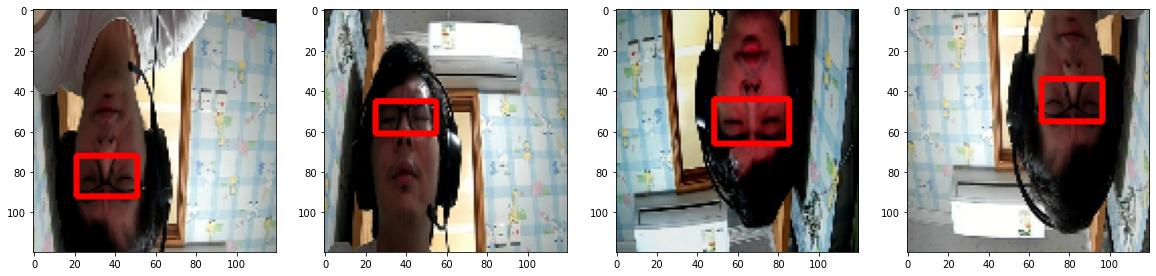

In [461]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = res[0][idx]
    sample_coords = res[1][1][idx]
    
    cv2.rectangle(sample_image, 
                  tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                        (255,0,0), 2)

    ax[idx].imshow(sample_image)

# 8. Build Deep Learning using the Functional API

### 8.1 Import Layers and Base Network

In [462]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

### 8.2 Download VGG16

In [463]:
vgg = VGG16(include_top=False)

In [464]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

### 8.3 Build instance of Network

In [465]:
def build_model(): 
    input_layer = Input(shape=(120,120,3))
    
    vgg = VGG16(include_top=False)(input_layer)

    # Classification Model  
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1, activation='sigmoid')(class1)
    
    # Bounding box model
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1)
    
    facetracker = Model(inputs=input_layer, outputs=[class2, regress2])
    return facetracker

### 8.4 Test out Neural Network

In [466]:
facetracker = build_model()

In [467]:
facetracker.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 120, 120, 3) 0                                            
__________________________________________________________________________________________________
vgg16 (Functional)              (None, None, None, 5 14714688    input_8[0][0]                    
__________________________________________________________________________________________________
global_max_pooling2d_4 (GlobalM (None, 512)          0           vgg16[0][0]                      
__________________________________________________________________________________________________
global_max_pooling2d_5 (GlobalM (None, 512)          0           vgg16[0][0]                      
____________________________________________________________________________________________

In [468]:
X, y = train.as_numpy_iterator().next()

In [469]:
X.shape

(8, 120, 120, 3)

In [470]:
classes, coords = facetracker.predict(X)

In [471]:
classes, coords

(array([[0.6670722 ],
        [0.7044475 ],
        [0.6116991 ],
        [0.6499455 ],
        [0.6724336 ],
        [0.6008602 ],
        [0.6372578 ],
        [0.66191524]], dtype=float32),
 array([[0.5335037 , 0.44302318, 0.55861145, 0.5816534 ],
        [0.60027575, 0.48302805, 0.6847266 , 0.6421749 ],
        [0.57864946, 0.3671453 , 0.5877428 , 0.62003845],
        [0.5568679 , 0.4426277 , 0.68101114, 0.6549585 ],
        [0.6005201 , 0.4081874 , 0.5985998 , 0.6324529 ],
        [0.57444835, 0.47183886, 0.60939986, 0.49328187],
        [0.65760005, 0.38416407, 0.57796884, 0.5965704 ],
        [0.5900981 , 0.41043156, 0.57139814, 0.60982966]], dtype=float32))

# 9. Define Losses and Optimizers

### 9.1 Define Optimizer and LR

In [472]:
batches_per_epoch = len(train)
lr_decay = (1./0.75 -1)/batches_per_epoch

In [473]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001, decay=lr_decay)

### 9.2 Create Localization Loss and Classification Loss

In [474]:
def localization_loss(y_true, yhat):            
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))
                  
    h_true = y_true[:,3] - y_true[:,1] 
    w_true = y_true[:,2] - y_true[:,0] 

    h_pred = yhat[:,3] - yhat[:,1] 
    w_pred = yhat[:,2] - yhat[:,0] 
    
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))
    
    return delta_coord + delta_size

In [475]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

### 9.3 Test out Loss Metrics

In [396]:
localization_loss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=6.2401695>

In [397]:
classloss(y[0], classes)

<tf.Tensor: shape=(), dtype=float32, numpy=1.0286558>

In [398]:
regressloss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=6.2401695>

# 10. Train Neural Network

### 10.1 Create Custom Model Class

In [399]:
class FaceTracker(Model): 
    def __init__(self, eyetracker,  **kwargs): 
        super().__init__(**kwargs)
        self.model = eyetracker

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt
    
    def train_step(self, batch, **kwargs): 
        
        X, y = batch
        
        with tf.GradientTape() as tape: 
            classes, coords = self.model(X, training=True)
            
            batch_classloss = self.closs(y[0], classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
            
            total_loss = batch_localizationloss+0.5*batch_classloss
            
            grad = tape.gradient(total_loss, self.model.trainable_variables)
        
        opt.apply_gradients(zip(grad, self.model.trainable_variables))
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
    
    def test_step(self, batch, **kwargs): 
        X, y = batch
        
        classes, coords = self.model(X, training=False)
        
        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss+0.5*batch_classloss
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
        
    def call(self, X, **kwargs): 
        return self.model(X, **kwargs)

In [400]:
model = FaceTracker(facetracker)

In [401]:
model.compile(opt, classloss, regressloss)

### 10.2 Train

In [402]:
logdir='logs'

In [403]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [404]:
hist = model.fit(train, epochs=10, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/10
128/128 [==============================] - 113s 878ms/step - total_loss: 0.1665 - class_loss: 0.0305 - regress_loss: 0.1513 - val_total_loss: 0.0175 - val_class_loss: 1.3815e-04 - val_regress_loss: 0.0174
Epoch 2/10
128/128 [==============================] - 108s 843ms/step - total_loss: 0.0185 - class_loss: 1.3135e-04 - regress_loss: 0.0184 - val_total_loss: 0.0297 - val_class_loss: 1.3585e-04 - val_regress_loss: 0.0296
Epoch 3/10
128/128 [==============================] - 108s 845ms/step - total_loss: 0.0112 - class_loss: 6.0238e-05 - regress_loss: 0.0112 - val_total_loss: 0.0138 - val_class_loss: 2.6562e-05 - val_regress_loss: 0.0138
Epoch 4/10
128/128 [==============================] - 105s 820ms/step - total_loss: 0.0076 - class_loss: 2.4872e-05 - regress_loss: 0.0076 - val_total_loss: 0.0138 - val_class_loss: 6.8290e-05 - val_regress_loss: 0.0137
Epoch 5/10
128/128 [==============================] - 103s 802ms/step - total_loss: 0.0050 - class_loss: 1.6942e-05 - regres

### 10.3 Plot Performance

In [405]:
hist.history

{'total_loss': [0.007042045705020428,
  0.013634313829243183,
  0.0017961879493668675,
  0.0029874411411583424,
  0.002758193528279662,
  0.0027419165708124638,
  0.0017540592234581709,
  0.0021344611886888742,
  0.00043564100633375347,
  0.0010900574270635843],
 'class_loss': [0.00029566267039626837,
  5.395916377892718e-05,
  1.1965723388129845e-05,
  5.212781979935244e-05,
  2.457262235111557e-05,
  4.276654181012418e-06,
  9.551738912705332e-06,
  3.93391610487015e-06,
  4.5597766984428745e-06,
  5.960466751275817e-07],
 'regress_loss': [0.006894214544445276,
  0.013607334345579147,
  0.0017902051331475377,
  0.0029613771475851536,
  0.002745907288044691,
  0.0027397782541811466,
  0.0017492834012955427,
  0.0021324942354112864,
  0.0004333611286710948,
  0.0010897594038397074],
 'val_total_loss': [0.01750277727842331,
  0.02965121902525425,
  0.01382441632449627,
  0.013780401088297367,
  0.018826931715011597,
  0.01492124330252409,
  0.009435570798814297,
  0.008373592048883438,


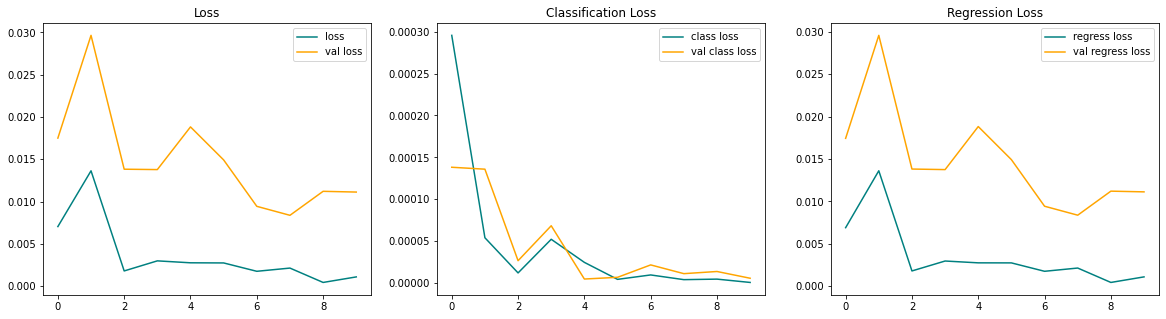

In [406]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

# 11. Make Predictions

### 11.1 Make Predictions on Test Set

In [407]:
test_data = test.as_numpy_iterator()

In [408]:
test_sample = test_data.next()

In [409]:
yhat = facetracker.predict(test_sample[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


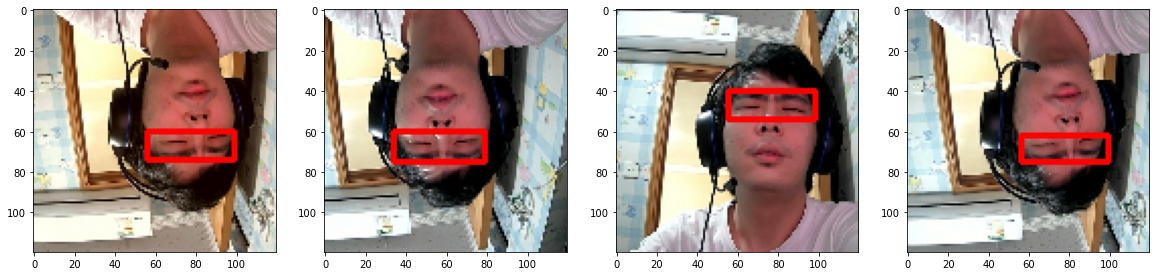

In [410]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = test_sample[0][idx]
    sample_coords = yhat[1][idx]
    
    if yhat[0][idx] > 0.9:
        cv2.rectangle(sample_image, 
                      tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                            (255,0,0), 2)
    
    ax[idx].imshow(sample_image)

### 11.2 Save the Model

In [7]:
from tensorflow.keras.models import load_model

In [412]:
facetracker.save('facetracker.h5')

In [8]:
facetracker = load_model('facetracker.h5')

### 11.3 Real Time Detection

In [9]:
cap = cv2.VideoCapture(0)
#cap = cv2.VideoCapture('http://192.168.1.27:4747/mjpegfeed?640x480%27')
while cap.isOpened():
    _ , frame = cap.read()
    frame = frame[50:500, 50:500,:]
    
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (120,120))
    
    yhat = facetracker.predict(np.expand_dims(resized/255,0))
    sample_coords = yhat[1][0]
    
    if yhat[0] > 0.5: 
        # Controls the main rectangle
        cv2.rectangle(frame, 
                      tuple(np.multiply(sample_coords[:2], [450,450]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [450,450]).astype(int)), 
                            (255,0,0), 2)
        # Controls the label rectangle
        cv2.rectangle(frame, 
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int), 
                                    [0,-30])),
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                    [80,0])), 
                            (255,0,0), -1)
        
        # Controls the text rendered
        cv2.putText(frame, 'face', tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                               [0,-5])),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
    
    cv2.imshow('EyeTrack', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()